Feature Matching Knowledge Distillation

Environment Setup and Dependencies

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.amp import GradScaler, autocast
import h5py
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score



# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Data Loading

In [11]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float = 0.80) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pd.api.types.is_numeric_dtype(submission.values):
        raise Exception('Submission target column must be numeric')

    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = -1.0 * np.asarray(submission.values)
    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    return partial_auc

In [12]:
class ISICDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

# Define data transformations
def get_transforms(mode='train'):
    if mode == 'train':
        return transforms.Compose([
            transforms.RandomResizedCrop(256),  # Crop to 256x256 (original images assumed larger)
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
        ])
    else:  # val or test
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
        ])

# Prepare data loaders (assuming images stored in "Data" directory)
def prepare_data(data_dir="./", max_label0_train=40000, val_label0_size=10000, val_label1_ratio=0.2, batch_size=32):
    # Load image paths
    benign_images = sorted([os.path.join(data_dir, "train-image-0_hairRemove", f) for f in os.listdir(os.path.join(data_dir, "train-image-0_hairRemove"))])
    
    malignant_main = sorted([os.path.join(data_dir, "train-image-1_hairRemove", f) for f in os.listdir(os.path.join(data_dir, "train-image-1_hairRemove"))])
    malignant_extra = sorted([os.path.join(data_dir, "extra-train-image-1_hairRemove", f) for f in os.listdir(os.path.join(data_dir, "extra-train-image-1_hairRemove"))])
    malignant_images = malignant_main + malignant_extra
    # Process label0 (benign)
    np.random.seed(42)
    benign_train = np.random.choice(benign_images, size=max_label0_train, replace=False)
    benign_val = [img for img in benign_images if img not in benign_train][:val_label0_size]
    
    # Process label1 (malignant) - keep all in training and split a small portion for validation
    malignant_train, malignant_val = train_test_split(
        malignant_images, test_size=val_label1_ratio, random_state=42
    )
    
    # Create final train/val lists
    train_imgs = list(benign_train) + list(malignant_train)
    train_labels = [0]*len(benign_train) + [1]*len(malignant_train)
    val_imgs = benign_val + malignant_val
    val_labels = [0]*len(benign_val) + [1]*len(malignant_val)
    
    # Shuffle training data
    train_data = list(zip(train_imgs, train_labels))
    np.random.shuffle(train_data)
    train_imgs, train_labels = zip(*train_data)
    
    # Create datasets and loaders
    train_dataset = ISICDataset(train_imgs, train_labels, transform=get_transforms('train'))
    val_dataset = ISICDataset(val_imgs, val_labels, transform=get_transforms('val'))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Print dataset sizes for reference
    print(f"Training set: {len(train_imgs)} images (0: {train_labels.count(0)}, 1: {train_labels.count(1)})")
    print(f"Validation set: {len(val_imgs)} images (0: {val_labels.count(0)}, 1: {val_labels.count(1)})")
    return train_loader, val_loader

# Prepare data loaders
train_loader, val_loader = prepare_data(batch_size=32)


Training set: 41672 images (0: 40000, 1: 1672)
Validation set: 10419 images (0: 10000, 1: 419)


Model Definitions (Teacher and Student)

In [13]:
import timm
import torch.nn as nn

class DistillableViT(nn.Module):
    def __init__(self, image_size=256, patch_size=16, num_classes=2, dim=384):
        super().__init__()
        self.vit = timm.create_model(
            'vit_small_patch16_224',
            pretrained=True,
            num_classes=num_classes,
            img_size=image_size,  # Now 256
            patch_size=patch_size
        )
        self.dim = dim  # 通常为384

    def forward(self, x):
        B = x.shape[0]
        # 获取嵌入 + 加位置信息
        x = self.vit.patch_embed(x)  # [B, N, C]
        cls_token = self.vit.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.vit.pos_embed
        x = self.vit.pos_drop(x)

        # 保存中间层
        mid_feats = []
        for i, blk in enumerate(self.vit.blocks):
            x = blk(x)
            if i == 3 or i == 7:
                # 保存第4层和第8层的patch token平均值
                mid_feats.append(x[:, 1:, :].mean(dim=1))  # 跳过cls token

        # 最后一层
        x = self.vit.norm(x)
        cls_out = self.vit.head(x[:, 0])  # [B, num_classes]
        final_feat = x[:, 1:, :].mean(dim=1)
        mid_feats.append(final_feat)

        return cls_out, mid_feats


In [14]:
def load_teacher_model():
    import timm
    import torch.nn as nn

    base_model = timm.create_model('swinv2_small_window8_256', pretrained=False,num_classes=2)
    base_model.load_state_dict(torch.load('clean_swin_weights.pth'))

    class SwinTeacherWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model.to(device)

        def forward(self, x):
            stage2_feat = None
            stage3_feat = None

            x = self.model.patch_embed(x)
            if hasattr(self.model, "pos_drop"):
                x = self.model.pos_drop(x)

            for i, layer in enumerate(self.model.layers):  # ✅ 这里改成 layers
                x = layer(x)
                if i == 1:
                    stage2_feat = x
                elif i == 2:
                    stage3_feat = x

            # x = self.model.norm(x)
            final_feat = x
            out = self.model.head(final_feat)

            return out, stage2_feat, stage3_feat, final_feat

    teacher_model = SwinTeacherWrapper(base_model)
    return teacher_model.to(device)  # ✅ 再整体转一次（保险）



Feature Matching Distillation Loss Implementation

In [ ]:
# class KnowledgeDistillationLoss(nn.Module):
#     def __init__(self, alpha=0.5, temperature=3.0, feature_adapter=None, class_weights=None):
#         super().__init__()
#         self.alpha = alpha
#         self.temperature = temperature
#         # 定义分类损失（交叉熵），考虑类别不平衡的权重
#         if class_weights is not None:
#             self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
#         else:
#             self.ce_loss = nn.CrossEntropyLoss()
#         # KL散度损失用于软目标（教师-学生概率分布）
#         self.kl_loss = nn.KLDivLoss(reduction='batchmean')
#         self.feature_adapter = feature_adapter
#     def forward(self, student_logits, student_features, teacher_logits, teacher_features, labels):
#         # 如果提供了特征适配器，则将教师特征投影到学生特征维度
#         if self.feature_adapter:
#             teacher_features = self.feature_adapter(teacher_features)
#         # 学生模型的类别预测损失
#         student_cls_loss = self.ce_loss(student_logits, labels)
#         # 教师与学生软标签的KL散度损失
#         soft_targets = nn.functional.softmax(teacher_logits / self.temperature, dim=1)
#         soft_predictions = nn.functional.log_softmax(student_logits / self.temperature, dim=1)
#         soft_loss = self.kl_loss(soft_predictions, soft_targets) * (self.temperature ** 2)
#         # 最后一层特征的MSE损失（学生蒸馏token vs 教师特征）
#         feature_loss = nn.functional.mse_loss(student_features, teacher_features)
#         # 综合损失：权重alpha用于平衡蒸馏损失和直接监督损失
#         loss = (1 - self.alpha) * student_cls_loss + self.alpha * (0.5 * soft_loss + 0.5 * feature_loss)
#         return loss

# 新的基于特征匹配的蒸馏损失实现
class FeatureMatchingLoss(nn.Module):
    def __init__(self, alpha=0.5, class_weights=None, teacher_dims=(192, 384, 768), student_dim=384):
        """ 
        alpha: 权衡项，用于平衡直接分类损失和特征蒸馏损失 
        teacher_dims: 教师模型所选中间层特征的通道维度 (stage2, stage3, final)
        student_dim: 学生模型特征维度(ViT小模型embedding维度)
        """
        super().__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        # # 分类损失（交叉熵）
        # if class_weights is not None:
        #     self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        # else:
        #     self.ce_loss = nn.CrossEntropyLoss()
        # 针对维度不匹配的特征投影层
        t_stage2_dim, t_stage3_dim, t_final_dim = teacher_dims
        #如果教师某层特征维度与学生不同，则建立线性层进行对齐
        self.adapter_stage2 = nn.Linear(t_stage2_dim, student_dim) if t_stage2_dim != student_dim else None
        self.adapter_stage3 = nn.Linear(t_stage3_dim, student_dim) if t_stage3_dim != student_dim else None
        self.adapter_final = nn.Linear(t_final_dim, student_dim) if t_final_dim != student_dim else None

    def forward(self, student_logits, student_features_list, teacher_features_list, labels):
        """
        student_features_list: [feat_stage2_student, feat_stage3_student, feat_final_student]
        teacher_features_list: [feat_stage2_teacher, feat_stage3_teacher, feat_final_teacher]
        每项 shape: [B, C] 或 [B, N, C]
        """
        # 计算分类交叉熵损失
        cls_loss = self.ce_loss(student_logits, labels)

        # 将教师特征送入 adapter（投影 student 的维度）
        if self.adapter_stage2:
            teacher_features_list[0] = self.adapter_stage2(self._pool_if_needed(teacher_features_list[0]))
            student_features_list[0] = self._pool_if_needed(student_features_list[0])
        if self.adapter_stage3:
            teacher_features_list[1] = self.adapter_stage3(self._pool_if_needed(teacher_features_list[1]))
            student_features_list[1] = self._pool_if_needed(student_features_list[1])
        if self.adapter_final:
            teacher_features_list[2] = self.adapter_final(self._pool_if_needed(teacher_features_list[2]))
            student_features_list[2] = self._pool_if_needed(student_features_list[2])

        # 计算三层特征的平均 MSE loss
        feature_loss = 0.0
        for s_feat, t_feat in zip(student_features_list, teacher_features_list):
            feature_loss += nn.functional.mse_loss(s_feat, t_feat)
        feature_loss = feature_loss / len(student_features_list)

        # 总损失 = 分类损失 + 特征蒸馏损失
        loss = (1 - self.alpha) * cls_loss + self.alpha * feature_loss
        return loss
    
    def _pool_if_needed(self, feat):
        # 如果是 [B, N, C] 格式，按N维平均
        if feat.dim() == 3:
            return feat.mean(dim=1)  # [B, N, C] -> [B, C]
        # 如果是 [B, C, H, W] 格式，按空间维平均
        if feat.dim() == 4:
            return feat.mean(dim=(2, 3))  # [B, C, H, W] -> [B, C]
        return feat


Training Loop with Feature Matching Distillation

In [16]:
def train_with_distillation(teacher_model, student_model, train_loader, val_loader,
                            num_epochs=10, lr=1e-4, weight_decay=1e-5, alpha=0.5,
                            patience=5, delta=0.001):
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()

    # 定义损失函数 (特征匹配蒸馏损失)
    class_weights = torch.tensor([0.01, 1.0]).to(device)  # 正负样本不平衡
    criterion = FeatureMatchingLoss(
        alpha=alpha,
        class_weights=class_weights,
        teacher_dims=(192, 384, 768),
        student_dim=student_model.dim
    ).to(device)

    # 优化器（包括学生模型参数 + adapter 参数）
    optimizer = optim.AdamW(
        list(student_model.parameters()) + list(criterion.parameters()),
        lr=lr, weight_decay=weight_decay
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    best_val_auc = 0.0
    best_model_path = 'best_student_model.pth'
    counter = 0  # Early stopping 计数

    def pool(x):
        if x.dim() == 4:
            return x.mean(dim=(2,3))
        if x.dim() == 3:
            return x.mean(dim=1)
        return x

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_logits, t_stage2, t_stage3, t_final = teacher_model(inputs)   

            s_logits, s_feat_list = student_model(inputs)

            # 对所有特征做 pooling，变成 [B, C]
            # 把 Swin 的 [B, H, W, C] → [B, C, H, W]，然后 pool 成 [B, C]
            def chw_pool(x):
                if x.dim() == 4 and x.shape[-1] in [192, 384, 768]:  # 如果是 Swin 输出格式
                    x = x.permute(0, 3, 1, 2)  # [B, H, W, C] → [B, C, H, W]
                return x.mean(dim=(2, 3))  # [B, C, H, W] → [B, C]

            t_feat_list = [chw_pool(t_stage2), chw_pool(t_stage3), chw_pool(t_final)]
            student_feat_list = [pool(f) for f in s_feat_list] 


            with autocast():
                loss = criterion(s_logits, student_feat_list, t_feat_list, labels)


            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 训练指标统计
            train_loss += loss.item()
            _, predicted = s_logits.float().max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            avg_loss = train_loss / (batch_idx + 1)
            acc = 100. * train_correct / train_total
            progress_bar.set_postfix(loss=avg_loss, acc=f'{acc:.2f}%')

        # 验证阶段
        student_model.eval()
        val_correct = 0
        val_total = 0
        val_preds = []
        val_targets = []
        progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)[0]  # 只取 logits
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                val_preds.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                acc = 100. * val_correct / val_total
                progress_bar_val.set_postfix(acc=f'{acc:.2f}%')

        val_auc = roc_auc_score(val_targets, val_preds)
        val_prauc = average_precision_score(val_targets, val_preds)
        # 构造 DataFrame
        val_ids = np.arange(len(val_preds))
        solution_df = pd.DataFrame({'id': val_ids, 'target': val_targets})
        submission_df = pd.DataFrame({'id': val_ids, 'target': val_preds})

        # 计算 partial AUC@TPR≥0.8
        val_pauc = score(solution_df, submission_df, row_id_column_name='id', min_tpr=0.8)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_loss:.4f} | Train Acc: {100.*train_correct/train_total:.2f}%')
        print(f'Val Acc: {100.*val_correct/val_total:.2f}% | Val AUC: {val_auc:.4f} | PR-AUC: {val_prauc:.4f} | pAUC@0.8: {val_pauc:.4f}')


        # Early stopping
        if val_prauc > best_val_auc + delta:
            best_val_auc = val_prauc
            torch.save(student_model.state_dict(), best_model_path)
            print(f'✅ Saved best model with PR-AUC: {val_prauc:.4f}')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("🛑 Early stopping triggered.")
                break

        scheduler.step()

    student_model.load_state_dict(torch.load(best_model_path))
    return student_model, best_val_auc



Trainning Trainning pipeline

In [17]:
def main():
    # 设置随机种子确保可复现
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 超参数设置
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    ALPHA = 0.8  # 蒸馏损失权重
    
    # 准备数据
    train_loader, val_loader = prepare_data(batch_size=BATCH_SIZE)
    # 加载教师模型和学生模型
    teacher_model = load_teacher_model()
    student_model = DistillableViT(image_size=256, patch_size=16, num_classes=2).to(device)
    
    # 不再需要单独的FeatureAdapter，因为FeatureMatchingLoss内部处理了维度对齐
    # feature_adapter = None
    
    # 训练学生模型（使用特征匹配蒸馏）
    trained_student, best_auc = train_with_distillation(
        teacher_model, student_model, train_loader, val_loader,
        num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,
        alpha=ALPHA, patience=7, delta=0.001
    )
    print(f"Training completed. Best validation AUC: {best_auc:.4f}")
    
    # 保存最终模型
    torch.save({
        'model_state_dict': trained_student.state_dict(),
        'best_auc': best_auc
    }, 'final_distilled_vit_small.pth')
    
    # 将模型转换为推理模型（移除蒸馏token的影响）
    inference_model = timm.create_model('vit_small_patch16_224', num_classes=2)
    # 将训练好的学生模型中ViT部分的权重复制到不含蒸馏token的ViT模型中
    inference_model.load_state_dict(trained_student.vit.state_dict(), strict=False)
    inference_model = inference_model.to(device)
    # 保存用于推理的模型权重
    torch.save(inference_model.state_dict(), 'inference_vit_small.pth')
    print("Model saved for inference")


In [18]:
main()


Training set: 41672 images (0: 40000, 1: 1672)
Validation set: 10419 images (0: 10000, 1: 419)


Epoch 1/50 [Train]:   0%|          | 0/1303 [00:00<?, ?it/s]


AttributeError: 'FeatureMatchingLoss' object has no attribute 'adapter_stage2'

In [ ]:
# ========= 1. 加载训练好的模型权重 =========
model = DistillableViT()
checkpoint = torch.load("final_distilled_vit_small.pth", map_location='cpu', weights_only= False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device).eval()

# ========= 2. 定义用于读取 HDF5 测试集的 Dataset =========
class HDF5TestDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.keys = list(h5py.File(h5_path, 'r').keys())
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            img_bytes = f[self.keys[idx]][()]
        image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.keys[idx]

# ========= 3. 创建 DataLoader =========
test_transform = get_transforms(mode='val')
test_dataset = HDF5TestDataset('test-image.hdf5', transform=test_transform)  # 替换为实际路径
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ========= 4. 生成预测并保存为 CSV =========
results = []
model.eval()
with torch.no_grad():
    for images, keys in tqdm(test_loader):
        images = images.to(device)
        logits, _ = model(images)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        results.extend(zip(keys, probs))

# ========= 5. 保存 submission.csv =========
submission_df = pd.DataFrame(results, columns=["isic_id", "target"])
submission_df.to_csv("submission.csv", index=False)
print("✅ Saved submission.csv")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'test-image.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Plot

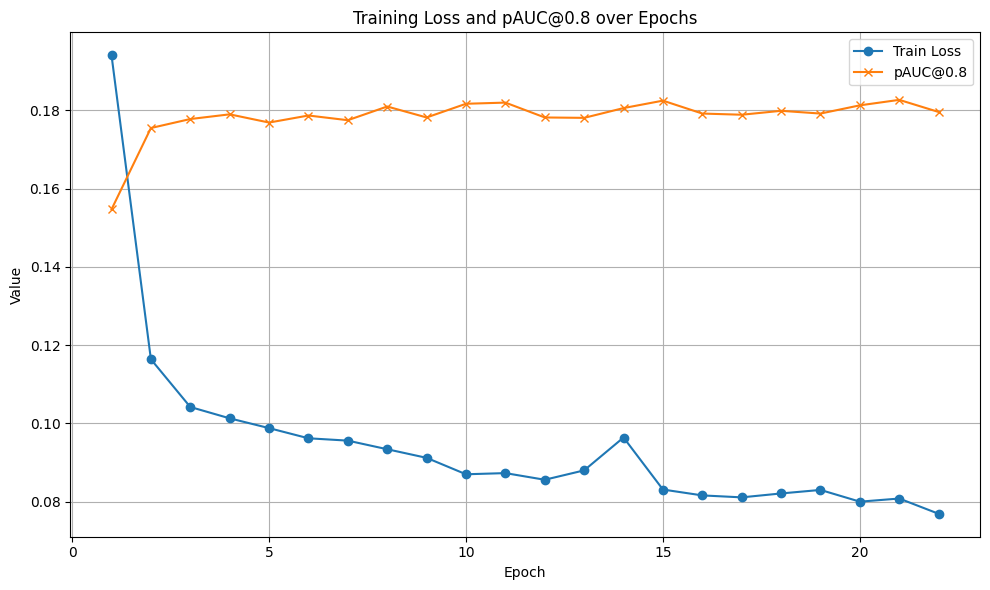

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 日志列表（每个元素是一个 epoch 的日志）
logs = [
    "Epoch 1/50:\nTrain Loss: 0.1941 | Train Acc: 93.61%\nVal Acc: 98.98% | Val AUC: 0.9547 | PR-AUC: 0.8884 | pAUC@0.8: 0.1547",
    "Epoch 2/50:\nTrain Loss: 0.1164 | Train Acc: 95.40%\nVal Acc: 97.20% | Val AUC: 0.9755 | PR-AUC: 0.9024 | pAUC@0.8: 0.1755",
    "Epoch 3/50:\nTrain Loss: 0.1042 | Train Acc: 95.52%\nVal Acc: 97.76% | Val AUC: 0.9778 | PR-AUC: 0.9051 | pAUC@0.8: 0.1778",
    "Epoch 4/50:\nTrain Loss: 0.1013 | Train Acc: 95.38%\nVal Acc: 98.87% | Val AUC: 0.9790 | PR-AUC: 0.9103 | pAUC@0.8: 0.1790",
    "Epoch 5/50:\nTrain Loss: 0.0988 | Train Acc: 95.54%\nVal Acc: 95.69% | Val AUC: 0.9769 | PR-AUC: 0.9088 | pAUC@0.8: 0.1769",
    "Epoch 6/50:\nTrain Loss: 0.0962 | Train Acc: 95.67%\nVal Acc: 94.39% | Val AUC: 0.9787 | PR-AUC: 0.9083 | pAUC@0.8: 0.1787",
    "Epoch 7/50:\nTrain Loss: 0.0956 | Train Acc: 95.15%\nVal Acc: 99.16% | Val AUC: 0.9775 | PR-AUC: 0.9058 | pAUC@0.8: 0.1775",
    "Epoch 8/50:\nTrain Loss: 0.0934 | Train Acc: 95.81%\nVal Acc: 94.63% | Val AUC: 0.9810 | PR-AUC: 0.9112 | pAUC@0.8: 0.1810",
    "Epoch 9/50:\nTrain Loss: 0.0912 | Train Acc: 95.86%\nVal Acc: 97.82% | Val AUC: 0.9782 | PR-AUC: 0.9037 | pAUC@0.8: 0.1782",
    "Epoch 10/50:\nTrain Loss: 0.0870 | Train Acc: 96.40%\nVal Acc: 95.66% | Val AUC: 0.9817 | PR-AUC: 0.9164 | pAUC@0.8: 0.1817",
    "Epoch 11/50:\nTrain Loss: 0.0873 | Train Acc: 96.00%\nVal Acc: 94.97% | Val AUC: 0.9820 | PR-AUC: 0.9149 | pAUC@0.8: 0.1820",
    "Epoch 12/50:\nTrain Loss: 0.0856 | Train Acc: 95.86%\nVal Acc: 98.21% | Val AUC: 0.9782 | PR-AUC: 0.9111 | pAUC@0.8: 0.1782",
    "Epoch 13/50:\nTrain Loss: 0.0880 | Train Acc: 95.94%\nVal Acc: 98.64% | Val AUC: 0.9781 | PR-AUC: 0.9124 | pAUC@0.8: 0.1781",
    "Epoch 14/50:\nTrain Loss: 0.0964 | Train Acc: 95.87%\nVal Acc: 98.33% | Val AUC: 0.9806 | PR-AUC: 0.9145 | pAUC@0.8: 0.1806",
    "Epoch 15/50:\nTrain Loss: 0.0831 | Train Acc: 96.22%\nVal Acc: 93.97% | Val AUC: 0.9825 | PR-AUC: 0.9175 | pAUC@0.8: 0.1825",
    "Epoch 16/50:\nTrain Loss: 0.0816 | Train Acc: 95.96%\nVal Acc: 97.40% | Val AUC: 0.9791 | PR-AUC: 0.9159 | pAUC@0.8: 0.1792",
    "Epoch 17/50:\nTrain Loss: 0.0811 | Train Acc: 96.20%\nVal Acc: 96.43% | Val AUC: 0.9789 | PR-AUC: 0.9136 | pAUC@0.8: 0.1789",
    "Epoch 18/50:\nTrain Loss: 0.0821 | Train Acc: 96.25%\nVal Acc: 97.73% | Val AUC: 0.9799 | PR-AUC: 0.9130 | pAUC@0.8: 0.1799",
    "Epoch 19/50:\nTrain Loss: 0.0830 | Train Acc: 95.75%\nVal Acc: 97.10% | Val AUC: 0.9792 | PR-AUC: 0.9145 | pAUC@0.8: 0.1792",
    "Epoch 20/50:\nTrain Loss: 0.0800 | Train Acc: 95.91%\nVal Acc: 97.25% | Val AUC: 0.9813 | PR-AUC: 0.9147 | pAUC@0.8: 0.1813",
    "Epoch 21/50:\nTrain Loss: 0.0808 | Train Acc: 95.92%\nVal Acc: 96.75% | Val AUC: 0.9827 | PR-AUC: 0.9183 | pAUC@0.8: 0.1827",
    "Epoch 22/50:\nTrain Loss: 0.0769 | Train Acc: 96.23%\nVal Acc: 98.01% | Val AUC: 0.9796 | PR-AUC: 0.9176 | pAUC@0.8: 0.1796"
]

# 提取每个 epoch 的指标
data = []
for log in logs:
    epoch_match = re.search(r"Epoch (\d+)/", log)
    loss_match = re.search(r"Train Loss: ([\d.]+)", log)
    pauc_match = re.search(r"pAUC@0\.8: ([\d.]+)", log)
    
    if epoch_match and loss_match and pauc_match:
        data.append({
            "Epoch": int(epoch_match.group(1)),
            "Train Loss": float(loss_match.group(1)),
            "pAUC@0.8": float(pauc_match.group(1))
        })

# 转为 DataFrame
df = pd.DataFrame(data)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss", marker='o')
plt.plot(df["Epoch"], df["pAUC@0.8"], label="pAUC@0.8", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and pAUC@0.8 over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
